# Purpose
The purpose of this Notebook is to learn how to consolidate numerical features from `data/immo_data202208_v2.parquet` in one column each.

# Summary

| Feature       | Complete Data found in/with                                    |
| ------------- | -------------------------------------------------------------- |
| Living Space  | Column `Living_area_unified` and fillna with `Space extracted` |
| Rooms         | Merge RegEx from `details_structured` and `No. of rooms:`      |
| Plot Area     | Like in v1 then fillna with `Land area:`                       |
| Floor Space   | Like in v1 then fillna with `Floor space:`                     |
| Floor         | `Floor` then fillna with `floor` from v1                       |
| Price         | Column `price_cleaned`                                         |
| Coordinates   | Columns `Latitude` and `Longitude`                             |

In [11]:
# Import modules
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")


In [12]:
df = pd.read_parquet(
    "https://github.com/Immobilienrechner-Challenge/data/blob/main/immo_data_202208_v2.parquet?raw=true"
)


# Living Space

In [this](./1-daw_columns.html) notebook we've found the following columns contain data on the living space:

- `Living space` (=)
- `Living_area_unified` (new)
- `Living_space_merged` (=)
- `Superficie abitabile` (=)
- `Surface habitable` (=)
- `Surface living:` (new)
- `Wohnfläche` (=)
- `detail_responsive#surface_living` (=)
- `Space extracted` (+8693)

By taking findings from unchanged columns into consideration we can omit some columns for further analysis.

In [13]:
# Select relevant columns
cols_living_space = ["Space extracted", "Living_area_unified", "Surface living:"]
df_living_space = df[cols_living_space]


## NA Heatmap

Like in the v1 analysis we again use a heatmap showing missing values to get an understanding about where the complete data can be found. 

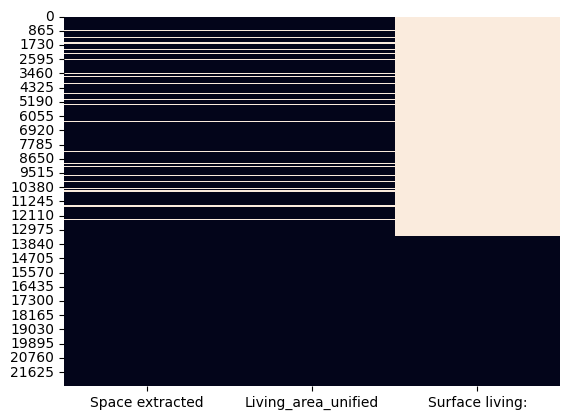

In [14]:
# Sort columns by number of non-null values
df_living_space = df_living_space.reindex(
    df_living_space.count().sort_values(ascending=False).index, axis=1
)

# Create isna heatmap
sns.heatmap(df_living_space.isna(), cbar=False)
plt.show()


This suggests that both `Space extracted` and `Living_area_unified` contain the complete dataset. To verify that `Surface living:` does not contain any information that `Living_area_unified` does not we parse and compare the two columns. 

In [19]:
# Parse Surface living: column
df_living_space["Surface living:"] = df_living_space["Surface living:"].str.replace(" m²", "")
df_living_space["Surface living:"] = df_living_space["Surface living:"].str.replace(" m2", "")
df_living_space["Surface living:"] = df_living_space["Surface living:"].astype(float)


In [24]:
# check if contents of "Sutface living:" are the same as "Living_area_unified"
(df_living_space["Surface living:"] == df_living_space["Living_area_unified"]).sum() == df_living_space["Surface living:"].count()

True

This count equals the number of rows added in this version of the dataset, so we can confirm that the column `Living_area_unified` contains all information present in `Surface living:` making it useless.

In [25]:
df_living_space.drop(["Surface living:"], axis=1, inplace=True)


We now compare the data in the two remaining columns to see if there's any difference. 

In [26]:
# Display rows where "Space extracted" is not null and "Living_area_unified" is null
df_living_space[
    df_living_space["Space extracted"].notna()
    & df_living_space["Living_area_unified"].isna()
]


,Space extracted,Living_area_unified


In [27]:
# Display rows where "Space extracted" is null and "Living_area_unified" is not null
df_living_space[
    df_living_space["Space extracted"].isna()
    & df_living_space["Living_area_unified"].notna()
]


,Space extracted,Living_area_unified


In [8]:
df_living_space[
    df_living_space["Space extracted"].fillna("")
    != df_living_space["Living_area_unified"].fillna("")
]


,Space extracted,Living_area_unified


In [28]:
# Check if all rows are equal
(
    df_living_space["Space extracted"].fillna("")
    == df_living_space["Living_area_unified"].fillna("")
).sum() == df_living_space.shape[0]


True

All rows are equal, so we can use either column for the living space.

# Rooms

- `No. of rooms:` (new)
- `rooms` (+8868)
- `details_structured`

In [29]:
cols_rooms = ["rooms", "No. of rooms:"]
df_rooms = df[cols_rooms]

df_rooms["from_details_structured"] = df.loc[
    df["provider"] == "Immoscout24.ch", "details_structured"
].str.extract(r"(\d+\.?\d?) rooms")


/tmp/ipykernel_18364/754778718.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rooms['from_details_structured'] = df.loc[df['provider'] == 'Immoscout24.ch', 'details_structured'].str.extract(r'(\d+\.?\d?) rooms')


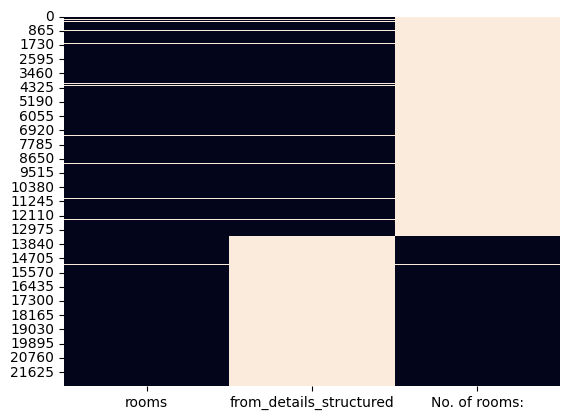

In [30]:
# sort columns by number of non-null values
df_rooms = df_rooms.reindex(df_rooms.count().sort_values(ascending=False).index, axis=1)
# create isna heatmap
sns.heatmap(df_rooms.isna(), cbar=False)
plt.show()


In the [previous version](../v1/exports/3-daw_quantitative.html) of this analysis we found that the column `rooms` didn't contain the correct data. 

In [17]:
df_rooms["rooms"].value_counts()


5.0       10916
4.5rm      2179
3.5rm      1624
5.5rm      1116
2.5rm       781
6.5rm       451
6rm         345
6.0         344
7.0         309
5rm         283
7rm         259
4.0         250
4rm         248
8.0         239
3.0         200
7.5rm       198
8rm         191
1.5rm       163
3rm         156
2.0         152
9.0         140
0.0         138
9rm         134
10rm        110
8.5rm       100
1.0          90
2rm          89
1rm          85
12rm         73
11rm         60
9.5rm        51
14rm         25
15rm         21
13rm         19
10.5rm       16
20rm         15
11.5rm        9
18rm          9
12.5rm        8
17rm          6
19rm          5
16rm          5
23rm          4
14.5rm        4
15.5rm        3
16.5rm        3
13.5rm        3
24rm          2
17.5rm        2
19.5rm        2
22rm          2
21rm          1
28.5rm        1
24.5rm        1
33rm          1
25rm          1
30rm          1
35rm          1
18.5rm        1
26rm          1
Name: rooms, dtype: int64

Still we can see that all values without the «rm» suffix do not contain .5 values which is why we prefer to mereg the columns in the following way.

In [32]:
df_rooms.drop("rooms", axis=1, inplace=True)


In [39]:
# merge from_details_structured and No. of rooms:
df_rooms["rooms"] = df_rooms["from_details_structured"].fillna(
    df_rooms["No. of rooms:"]
)


In [40]:
df_rooms["rooms"].value_counts()


4.5     3469
3.5     2312
5.5     2183
4.5     2179
3.5     1624
        ... 
21.0       1
28.5       1
29         1
22         1
26.0       1
Name: rooms, Length: 92, dtype: int64

In [41]:
df_rooms["rooms"].count()


21647

# Plot Area
- `Land area:` (new)
- `Plot_area_merged` (=)
- `Plot_area_unified` (new)
- `detail_responsive#surface_property` (=)

In [48]:
cols_plot_area = ["Land area:", "Plot_area_unified"]
df_plot_area = df[cols_plot_area]

df_plot_area["plot_area"] = df["Plot_area_merged"].fillna("") + df[
    "detail_responsive#surface_property"
].fillna("")
df_plot_area["plot_area"] = (
    df_plot_area["plot_area"].replace("", np.nan).str.extract("(\d+,?\d*)")
)


/tmp/ipykernel_18364/2505688876.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot_area['plot_area'] = df['Plot_area_merged'].fillna('') + \
/tmp/ipykernel_18364/2505688876.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot_area['plot_area'] = df_plot_area['plot_area'].replace('', np.nan).str.extract('(\d+,?\d*)')


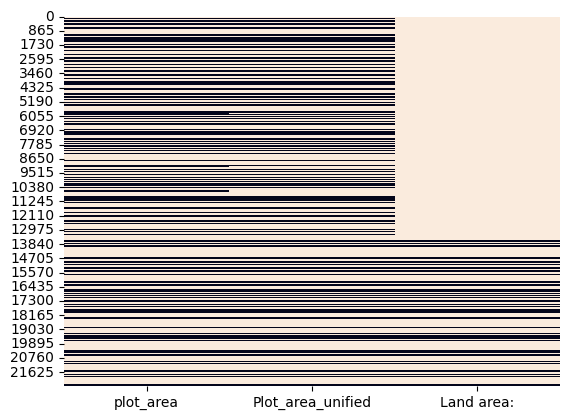

In [51]:
# sort columns by number of non-null values
df_plot_area = df_plot_area.reindex(
    df_plot_area.count().sort_values(ascending=False).index, axis=1
)
# create isna heatmap
sns.heatmap(df_plot_area.isna(), cbar=False)
plt.show()


In [50]:
df_plot_area["plot_area"] = df_plot_area["plot_area"].fillna(df_plot_area["Land area:"])


In [53]:
df_plot_area["plot_area"].count()


8210

Deal with `Minimum floor space` (new)

# Floor Space
- `Floor space:` (new)
- `Floor_space_merged` (=)
- `detail_responsive#surface_usable` (=) 

In [54]:
cols_floor_space = ["Floor space:"]
df_floor_space = df[cols_floor_space]

df_floor_space["floor_space"] = df["Floor_space_merged"].fillna("") + df[
    "detail_responsive#surface_usable"
].fillna("")
df_floor_space["floor_space"] = (
    df_floor_space["floor_space"].replace("", np.nan).str.extract("(\d+,?\d*)")
)


/tmp/ipykernel_18364/2994546443.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_floor_space['floor_space'] = df['Floor_space_merged'].fillna('') + \
/tmp/ipykernel_18364/2994546443.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_floor_space['floor_space'] = df_floor_space['floor_space'].replace('', np.nan).str.extract('(\d+,?\d*)')


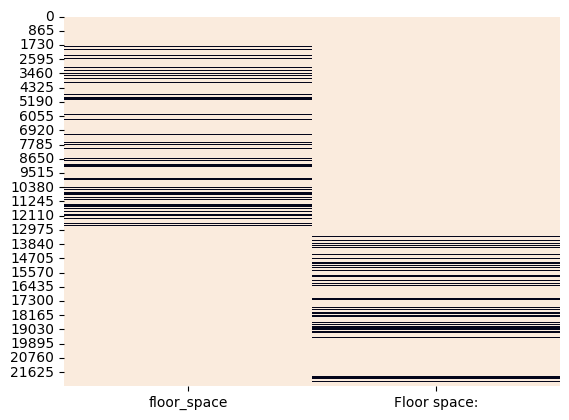

In [55]:
# sort columns by number of non-null values
df_floor_space = df_floor_space.reindex(
    df_floor_space.count().sort_values(ascending=False).index, axis=1
)
# create isna heatmap
sns.heatmap(df_floor_space.isna(), cbar=False)
plt.show()


In [56]:
df_floor_space["floor_space"] = df_floor_space["floor_space"].fillna(
    df_floor_space["Floor space:"]
)


In [57]:
df_floor_space["floor_space"].count()


5708

# Floor
- `Floor` (+4636)
- `Floor_merged` (=)
- `Floor_unified` (new)
- `detail_responsive#floor` (=)

In [58]:
cols_floor = ["Floor", "Floor_unified"]
df_floor = df[cols_floor]

df_floor["floor"] = df["Floor_merged"].fillna("") + df[
    "detail_responsive#floor"
].fillna("")
df_floor["floor"] = df_floor["floor"].replace("", np.nan)


/tmp/ipykernel_18364/78792940.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_floor['floor'] = df['Floor_merged'].fillna('') + \
/tmp/ipykernel_18364/78792940.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_floor['floor'] = df_floor['floor'].replace('', np.nan)


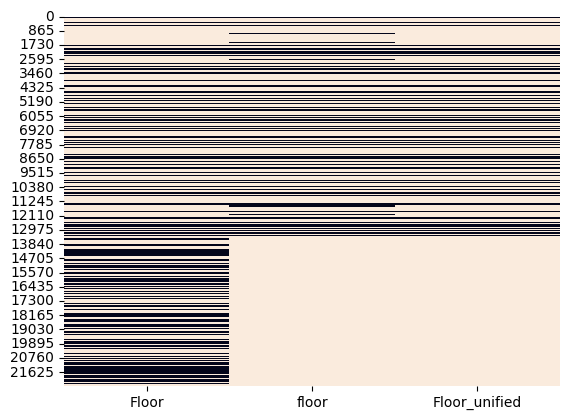

In [59]:
# sort columns by number of non-null values
df_floor = df_floor.reindex(df_floor.count().sort_values(ascending=False).index, axis=1)
# create isna heatmap
sns.heatmap(df_floor.isna(), cbar=False)
plt.show()


In [63]:
(
    df_floor[df_floor["Floor"].notna() & df_floor["floor"].notna()]["Floor"]
    != df_floor[df_floor["Floor"].notna() & df_floor["floor"].notna()]["floor"]
).sum()


0

In [74]:
df_floor["Floor"] = df_floor["Floor"].fillna(df_floor["floor"])


In [75]:
df_floor["Floor"].value_counts()


1. floor        1747
Ground floor    1388
1               1332
2. floor        1326
GF              1191
2               1032
3. floor         693
3                597
4. floor         265
4                249
5. floor          91
5                 84
6                 45
6. floor          39
7                 25
999               23
7. floor          20
8                 16
-1                13
10                12
8. floor           6
9                  5
2. Basement        5
999. floor         5
11                 4
10. floor          4
9. floor           4
11. floor          3
12                 3
12. floor          3
1. Basement        3
23                 2
14. floor          2
23. floor          2
-3                 1
-2                 1
195                1
24                 1
-4                 1
13                 1
3. Basement        1
16                 1
20                 1
1011               1
15. floor          1
4. Basement        1
100. floor         1
21. floor    

In [ ]:
# needs to be parsed and cleaned


# Price
- `price` (+9126)
- `price_cleaned` (+9126)
- `price_s` (new)

In [66]:
cols_price = ["price", "price_cleaned", "price_s"]
df_price = df[cols_price]


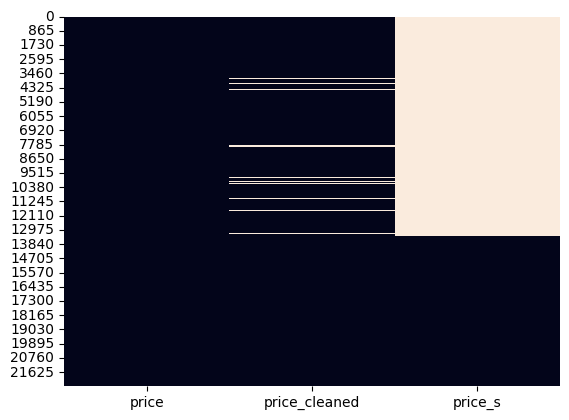

In [67]:
# sort columns by number of non-null values
df_price = df_price.reindex(df_price.count().sort_values(ascending=False).index, axis=1)
# create isna heatmap
sns.heatmap(df_price.isna(), cbar=False)
plt.show()


In [69]:
df_price["price_cleaned"].value_counts()


850000.0     225
650000.0     217
890000.0     202
790000.0     200
1250000.0    197
            ... 
1456000.0      1
396000.0       1
1949900.0      1
399500.0       1
1088888.0      1
Name: price_cleaned, Length: 1752, dtype: int64

# Coordinates
- `Latitude` (+9126)
- `lat` (+9126)
- `Longitude` (+9126)
- `lon`(9126)

In [70]:
cols_coordinates = ["lat", "lon", "Latitude", "Longitude"]
df_coordinates = df[cols_coordinates]


In [71]:
# Get number of isnull values
df_coordinates.isnull().sum()


lat          17
lon          17
Latitude      0
Longitude     0
dtype: int64